In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/Shareddrives/M202A Embedded Systems Project/Data_csv'

/content/drive/Shareddrives/M202A Embedded Systems Project/Data_csv


In [4]:
import numpy as np
import pandas as pd
from os import listdir
import os.path
import zipfile
from keras.utils.np_utils import to_categorical
import json
from sklearn.model_selection import train_test_split
# import pykalman

In [5]:
def get_header():
    header = ["acc_x", "acc_y","acc_z", "gyro_x", "gyro_y","gyro_z", "activityID"]
    return header

def addheader(datasets):
    """
    The columns of the pandas data frame are numbers
    this function adds the column labels
    Parameters
    ----------
    datasets : list
        List of pandas dataframes
    """
    header = get_header()
    for i in range(0, len(datasets)):
        datasets[i].columns = header
    return datasets

In [6]:
def clip_data(ds):
  '''
  Takes in a data set and slices it to the first activityID and last activityID
  Inputs:
    - ds: a pandas dataset
  Returns:
    - ds: sliced pandas dataset, starting at the first nonzero activity ID and ending at the last nonzero activityID
  '''
  return ds[ds[ds.activityID != 0].first_valid_index():ds[ds.activityID != 0].last_valid_index()+1]

In [7]:
def sliding_window(frame_length, step, Xsampleslist, ysampleslist):
    """
    Splits time series in ysampleslist and Xsampleslist
    into segments by applying a sliding overlapping window
    of size equal to frame_length with steps equal to step
    it does this for all the samples and appends all the output together.
    So, the participant distinction is not kept
    Parameters
    ----------
    frame_length : int
        Length of sliding window
    step : int
        Stepsize between windows
    Xsamples : list
        Existing list of window fragments
    ysamples : list
        Existing list of window fragments
    Xsampleslist : list
        Samples to take sliding windows from
    ysampleslist
        Samples to take sliding windows from
    """
    Xsamples = []
    ysamples = []
    for j in range(len(Xsampleslist)):
        X = Xsampleslist[j]
        y = ysampleslist[j]
        for i in range(0, X.shape[0] - frame_length, step):
            xsub = X[i:i + frame_length, :]
            ysub = 0
            for z in range(i,i + frame_length + 1, 1):
              if y[z] == 1:
                ysub = 1
            # ysub = y
            Xsamples.append(xsub)
            ysamples.append(ysub)
    return Xsamples, ysamples

In [8]:
columns_to_use = ["acc_x", "acc_y","acc_z", "gyro_x", "gyro_y","gyro_z"]

datadir = os.path.join('/content/drive/Shareddrives/M202A Embedded Systems Project/Data_csv');
filenames = os.listdir(datadir)
filenames.sort()
datasets = [pd.read_csv(os.path.join(datadir, fn), header=None, sep=',')
            for fn in filenames]
#print(datasets)
datasets = addheader(datasets)
datasets_filled = [d.interpolate() for d in datasets]
datasets_clipped = [clip_data(ds) for ds in datasets_filled]

# Create input (x) and output (y) sets
xall = [np.array(data[columns_to_use]) for data in datasets_clipped]
yall = [np.array(data.activityID) for data in datasets_clipped]
yall_one = [[0 if val == 0 else 1 for val in data] for data in yall] # replaces all 1-5 with 1 for binary classifier
# Divide data into windows
# xall, yall_one = sliding_window(10, 5, xall, yall_one) # function taken directly from Vikranth's github--may need adjusting

In [9]:
# display(yall_one)
display(xall[0].shape[0])
print(xall[1].shape)
print(len(xall))
print(len(yall_one))

787

(778, 6)
80
80


In [10]:
X_train, X_test, y_train, y_test = train_test_split(xall, yall_one , test_size=0.20, random_state=9)
# display(X_test)

# window with 40 samples, each sample has 6 sensor data (acc x,y,z & gyro x,y,z) Thus, total of 240 sensor data in each window
x_tr, y_tr = sliding_window(40,1,X_train,y_train)
x_te, y_te = sliding_window(40,1,X_test,y_test)

# x_tr = np.concatenate(x_tr)
# y_tr = np.concatenate(y_train)
# x_te = np.concatenate(X_test)
# y_te = np.concatenate(y_test)

# flatten out the 40*6 samples (2 dimension) into 240 samples (1 dimension) for x_train & x_test, since y is 1 dimension
# x_tr_temp = []
# x_te_temp = []

# for i in range(0,len(x_tr),1):
#   x_tr_sub = np.concatenate(x_tr[i])
#   x_tr_temp.append(x_tr_sub)

# for i in range(0,len(x_te),1):
#   x_te_sub = np.concatenate(x_te[i])
#   x_te_temp.append(x_te_sub)

x_tr = np.reshape(x_tr, (-1,240))
x_te = np.reshape(x_te, (-1,240))
# x_te = X_test
# y_tr = y_train
# y_te = y_test
# display(y_tr)

In [11]:
display(len(x_tr))
display(len(y_tr))
display(x_te)

27587

27587

array([[  0.04187 ,  -0.356201,   1.011475, ...,  -1.77002 ,   6.408691,
         -7.324219],
       [  0.052979,  -0.339844,   0.986084, ...,  -1.586914,   5.981445,
         -7.385254],
       [  0.056152,  -0.347412,   0.97644 , ...,  -0.976562,   5.187988,
         -7.568359],
       ...,
       [  0.13562 ,  -0.114868,   0.91626 , ...,   2.075195, -17.028809,
         -2.075195],
       [  0.136353,  -0.111694,   0.911621, ...,   5.493164, -11.779785,
         -1.525879],
       [  0.138306,  -0.104736,   0.909302, ...,   5.432129,  -7.568359,
         -1.89209 ]])

In [12]:
# display(x_tr)
# display(y_tr)
# x_tr_mean = []
# x_te_mean = []

# for i in range(0,len(x_tr),1):
#   x_tr_sub = np.mean(x_tr[i])
#   x_tr_mean.append(x_tr_sub)

# for i in range(0,len(x_te),1):
#   x_te_sub = np.mean(x_te[i])
#   x_te_mean.append(x_te_sub)

# x_tr_mean_arr = np.reshape(x_tr_mean, (-1,1))
# x_te_mean_arr = np.reshape(x_te_mean, (-1,1))
# x_tr_mean_arr = np.array(x_tr_mean)

# display(x_tr_mean_arr)
# display(y_tr)

In [13]:
print(X_train[0].shape)
print(len(X_train))
print(len(y_train))
print(x_tr[0].shape)
print(len(x_tr))
print(len(y_tr))
# print(y_te)

(701, 6)
64
64
(240,)
27587
27587


In [14]:
# Import different types of classifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

# model = BaggingClassifier(base_estimator=LinearSVC(),n_estimators=10, random_state=0)
# model = KNeighborsClassifier()
# model = GaussianNB()
model_binary = RandomForestClassifier()
# model = DecisionTreeClassifier()
# model = LogisticRegression()
# model = LinearSVC()

model_binary.fit(x_tr, y_tr)

RandomForestClassifier()

array([[3148,   31],
       [  35, 2375]])

Accuracy = 0.98819, Precision = 0.98712, Recall = 0.98548


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


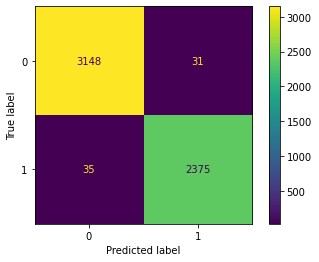

Accuracy = 0.98819, Precision = 0.98712, Recall = 0.98548


In [15]:
predictions = model_binary.predict(x_te)
# display(predictions)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_te, predictions)
display(cm)

accuracy = accuracy_score(y_te, predictions)
precision = precision_score(y_te, predictions)
recall = recall_score(y_te, predictions)
print('Accuracy = {:0.5f}, Precision = {:0.5f}, Recall = {:0.5f}'.format(accuracy,precision,recall))

plot_confusion_matrix(model_binary, x_te, y_te)  
plt.show()
print('Accuracy = {:0.5f}, Precision = {:0.5f}, Recall = {:0.5f}'.format(accuracy,precision,recall))

In [17]:
z = 0
while(z < len(predictions)/5):
  print(predictions[z], y_te[z])
  z = z + 1

1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
